# ML ШИФТ

# Содержание

- [1 Описание задачи](#1)
- [2 Импорт библиотек](#2)
- [3 Первичный анализ и предобработка данных](#3)
- [4 Генерирование признаков](#4)
- [5 Анализ данных](#5)
  - [5.1 Повторное срабатывание турникетов](#6)
  - [5.2 Количество проходов через турникеты в неделю](#7)
  - [5.3 Phik корреляция признаков с целевым признаком](#8)
- [6 Построение моделей](#9)
  - [6.1 Подготовка данных](#10)
  - [6.2 Подбор гиперпараметров](#11)
  - [6.3 Отбор признаков](#12)
  - [6.4 Подбор гиперпараметров после отбора признаков](#13)
  - [6.5 Итоговое предсказание лучшей модели](#14)


<a id='1'></a>
# 1 Описание задачи


Чтобы попасть в здание, нужно пройти через турникет. Чтобы открыть парковку, нужно открыть шлагбаум. Чтобы попасть на этаж, нужно приложить 'таблетку'. Все это фиксируется - кто, в какую дату, в какое время.
Сможем ли мы выучить, кому конкретно принадлежит 'след' прохода через турникеты? Мы знаем, что это был кто-то, кто уже был. (Правда, есть и несколько новых - не больше 10%).

'8 утра понедельник, турникет 4? Директор.' '11 утра суббота? Гриша. Но Гриша в последний день месяца никогда не приходит.'  Какие есть паттерны в настоящих данных?

**Цель** - предсказать, кто вошел в здание по времени и турникету.

**Описание данных**

В обучающей выборке:

* `user_id` - ID посетителя
* `ts` - дата и время прохождения через турникет
* `gate_id` - ID турникета

В тестовой выборке `user_id` заменены на слова: `aucroc, binary, blue, categorical` и т.п.

Требуется составить таблицу вида:

| user_word | preds |
| --- | --- |
| aucroc | 50 |
| binary | 11 |
| blue | -999 |
| ... | ... |

* `user_word` - закодированные ID пользователей
* `preds` - предсказанные ID
* `-999` - ID нового посетителя, которого раньше не было

Таблицу нужно запомнить как `csv` и потом заархивировать в `zip` архив. 

Каждому слову сопоставлен вес, который зависит от того, насколько трудно предсказать ID. Баллы набираются как взвешенная по весам сумма правильных ответов. Чем сложнее отгадали слово, тем больше баллов.

Посетителей здания будем считать сотрудниками некой компании.

<a id='2'></a>
# 2 Импорт библиотек


In [1]:
import io
import warnings
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import phik
import plotly.graph_objects as go
import seaborn as sns
import sklearn

from catboost import (CatBoostClassifier,
                      EFeaturesSelectionAlgorithm,
                      EShapCalcType,
                      Pool)
from scipy.stats import mode
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

RANDOM_STATE = 42

<a id='3'></a>
# 3 Первичный анализ и предобработка данных


In [3]:
df_train = pd.read_csv('../data/train.csv', index_col=[0], parse_dates=[2])
df_test = pd.read_csv('../data/test.csv', index_col=[0], parse_dates=[1])
ex_submit = pd.read_csv('../data/submit.csv')

In [4]:
for name, df in zip(['Тренировочная выборка', 'Тестовая выборка', 'Пример решения'], [df_train, df_test, ex_submit]):
    print(f'\033[1m{name}:\033[0m')
    display(df)
    if name != 'Пример решения':
        print(f'\033[1mОбщая информация - {name}:\033[0m')
        df.info()
        print(f'\033[1mКоличество пропусков: {df.isna().sum().sum()}\033[0m')
        print(f'\033[1mКоличество явных дубликатов: {df.duplicated().sum()}\033[0m')
        print()

Тренировочная выборка:


,user_id,ts,gate_id
0,18,2022-07-29 09:08:54,7
1,18,2022-07-29 09:09:54,9
2,18,2022-07-29 09:09:54,9
3,18,2022-07-29 09:10:06,5
4,18,2022-07-29 09:10:08,5
...,...,...,...
37513,6,2022-12-31 20:38:56,11
37514,6,2022-12-31 20:39:22,6
37515,6,2022-12-31 20:39:23,6
37516,6,2022-12-31 20:39:31,9


Общая информация - Тренировочная выборка:
<class 'pandas.core.frame.DataFrame'>
Index: 37518 entries, 0 to 37517
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   user_id  37518 non-null  int64         
 1   ts       37518 non-null  datetime64[ns]
 2   gate_id  37518 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB
Количество пропусков: 0
Количество явных дубликатов: 2346

Тестовая выборка:


,ts,gate_id,user_word
37518,2023-01-03 08:21:00,9,gini
37519,2023-01-03 08:21:00,9,gini
37520,2023-01-03 08:21:18,5,gini
37521,2023-01-03 08:21:19,5,gini
37522,2023-01-03 08:21:39,10,gini
...,...,...,...
44638,2023-02-24 19:43:36,11,collinear
44639,2023-02-24 19:44:00,4,collinear
44640,2023-02-24 19:44:01,4,collinear
44641,2023-02-24 19:44:09,9,collinear


Общая информация - Тестовая выборка:
<class 'pandas.core.frame.DataFrame'>
Index: 7125 entries, 37518 to 44642
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ts         7125 non-null   datetime64[ns]
 1   gate_id    7125 non-null   int64         
 2   user_word  7125 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 222.7+ KB
Количество пропусков: 0
Количество явных дубликатов: 505

Пример решения:


,user_word,preds
0,aucroc,49
1,binary,12
2,blue,55
3,categorical,14
4,coefficient,15
5,collinear,12
6,distributed,12
7,epsilon,1
8,f1,37
9,fit,3


Пропусков в данных не обнаружено.

В тренировочной и тестовой выборке есть явные дубликаты, удалим их.

In [5]:
df_train = df_train.drop_duplicates().reset_index(drop=True)
df_test = df_test.drop_duplicates().reset_index(drop=True)

In [6]:
df_train.shape

(35172, 3)

In [7]:
df_test.shape

(6620, 3)

In [8]:
df_train.ts.agg([min, max]).to_frame()

,ts
min,2022-07-29 09:08:54
max,2022-12-31 20:39:31


In [9]:
df_test.ts.agg([min, max]).to_frame()

,ts
min,2023-01-03 08:21:00
max,2023-02-24 19:44:09


In [10]:
(df_test.ts.max() - df_train.ts.min()).days // 30

7

Предоставлены данные за 7 месяцев - с июля 2022 по фефраль 2023. Номер месяца в качестве признака не подойдет.

ID сотрудников в тренировочной выборке

In [11]:
# id сотрудников в train
print(*sorted(df_train.user_id.unique()), sep=', ')
print(f'Количество сотрудников в train: {df_train.user_id.nunique()}')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57
Количество сотрудников в train: 56


In [12]:
# отсутствующие id
set(range(0, 58)) - set(df_train.user_id.unique())

{13, 16}

In [13]:
# активность сотрудников в train
count_user_id = pd.concat([df_train.user_id.value_counts(), df_train.user_id.value_counts(normalize=True)*100], axis=1)
count_user_id.columns = ['Абсолютная частота', 'Проценты']
count_user_id.astype('object').T

user_id,37,55,6,12,19,15,18,53,11,47,33,0,1,49,39,32,9,54,50,29,3,48,17,14,35,27,57,46,24,42,26,34,23,40,25,31,56,43,20,41,22,28,45,7,36,2,8,10,38,5,30,52,21,44,51,4
Абсолютная частота,2184,2166,1857,1837,1661,1659,1441,1279,1255,1250,1184,1184,1171,1129,1032,1020,1015,977,965,924,894,712,648,617,549,523,482,475,386,340,279,267,247,242,238,181,129,117,112,110,87,64,57,48,45,39,27,17,13,10,10,5,5,4,2,1
Проценты,6.21,6.16,5.28,5.22,4.72,4.72,4.10,3.64,3.57,3.55,3.37,3.37,3.33,3.21,2.93,2.90,2.89,2.78,2.74,2.63,2.54,2.02,1.84,1.75,1.56,1.49,1.37,1.35,1.10,0.97,0.79,0.76,0.70,0.69,0.68,0.51,0.37,0.33,0.32,0.31,0.25,0.18,0.16,0.14,0.13,0.11,0.08,0.05,0.04,0.03,0.03,0.01,0.01,0.01,0.01,0.00


ID сотрудников в тестовой выборке

In [14]:
print(*sorted(df_test.user_word.unique()), sep=', ')
print(f'Количество сотрудников в test: {df_test.user_word.nunique()}')

aucroc, binary, blue, categorical, coefficient, collinear, distributed, epsilon, f1, fit, gini, independent, lasso, linear, logistic, loss, matrix, minimization, mse, ols, precision, predict, pvalue, r2, recall, regression, residual, ridge, sigmoid, significant, target, tstat, x, y
Количество сотрудников в test: 34


In [15]:
# по условию сказано, что в тестовой выборке может быть не более 10% новых сотрудников
int(.1 * df_test.user_word.nunique())

3

In [16]:
# активность сотрудников в test
count_user_word = pd.concat([df_test.user_word.value_counts(), df_test.user_word.value_counts(normalize=True)*100], axis=1)
count_user_word.columns = ['Абсолютная частота', 'Проценты']
count_user_word.astype('object').T

user_word,f1,loss,sigmoid,binary,epsilon,collinear,x,independent,significant,gini,categorical,residual,recall,predict,linear,r2,fit,pvalue,matrix,ridge,ols,tstat,distributed,target,mse,minimization,coefficient,precision,regression,y,aucroc,lasso,blue,logistic
Абсолютная частота,694,458,432,362,336,298,298,278,277,253,245,224,210,208,199,185,183,181,157,141,139,139,117,111,103,95,56,54,50,50,37,33,12,5
Проценты,10.48,6.92,6.53,5.47,5.08,4.50,4.50,4.20,4.18,3.82,3.70,3.38,3.17,3.14,3.01,2.79,2.76,2.73,2.37,2.13,2.10,2.10,1.77,1.68,1.56,1.44,0.85,0.82,0.76,0.76,0.56,0.50,0.18,0.08


Рассмотрим распределение количества пересечений турникетов по дням каждым сотрудником из обеих выборок

In [17]:
df_train['date'] = df_train.ts.dt.date
df_test['date'] = df_test.ts.dt.date

# временно переименуем колонку `user_word` на `user_id`
df_test = df_test.rename(columns={'user_word': 'user_id'})

In [18]:
def plot_pass_count(df):
    pivot_df = pd.pivot_table(
        df,
        index='date',
        columns='user_id',
        values='gate_id',
        aggfunc='count',
        fill_value=0
    )
    fig = go.Figure()

    users = pivot_df.columns
    for user in users:
        fig.add_trace(go.Bar(
            x=pivot_df.index,
            y=pivot_df[user],
            name=f'user_id = {user}',
            marker_color='purple',
            visible=False   # все графики невидимы изначально
        ))

    # показываем первый график по умолчанию
    fig.data[0].visible = True

    # создание выпадающего списка для переключения между посетителями
    dropdown_buttons = [
        dict(
            label=f'Сотрудник {user}',
            method='update',
            args=[{'visible': [u == user for u in users]},
                {'title': f'Количество пересечений турникетов сотрудником {user}'}]
        ) for user in users
    ]

    # добавление выпадающего списка в макет графика
    fig.update_layout(
        updatemenus=[
            dict(
                active=0,
                buttons=dropdown_buttons,
                x=0.1,
                xanchor='left',
                y=1.15,
                yanchor='top'
            )
        ],
        title=f'Количество пересечений турникетов сотрудником {users[0]}',
        xaxis_title='Дата',
        yaxis_title='Количество проходов',
        showlegend=False,
        plot_bgcolor='white',
        paper_bgcolor='white',
        xaxis=dict(
            linecolor='darkgray',
            linewidth=1,
            tickformat='%d.%m.%y',
            dtick='M1',
        ),
        yaxis=dict(
            linecolor='darkgray',
            linewidth=1,
            showgrid=True,
            gridcolor='lightgray',
            gridwidth=.5
        )
    )

    fig.show()

In [19]:
# на выпадающем списке id сотрудников есть серый ползунок справа для перемещения по списку 
# (еще можно с зажатой левой кнопкой мыши перемещаться)
plot_pass_count(df_train)

In [20]:
plot_pass_count(df_test)

Удалим из обучающей выборки слишком маленькие категории сотрудников. Также исключим некоторых сотрудников из тренировочной выборки, исходя из графиков посещений здания для каждого сотрудника. Их выбор основан на резком изменеии поведения, большим временным промежутком, в течение которого они не посещают здание.

* 4, 51, 44, 21, 52, 30, 5, 38, 10, 8 - мало записей
* 7 - последний раз был в здании 24 октября
* 18 - прекратил свое стандартное поведение 26 октября
* 20 - последний раз был в здании 17 августа
* 27 - с августа по середину сентября выходил пять дней в неделю, затем - пререрыв, 7 раз был в октябре, 1 раз - в конце ноября
* 28 - последнее появление 20 октября
* 31 - изменение поведения, последний раз был 17 октября (только один проход)
* 40 - последнее появление 14 октября
* 42 - последний раз был в здании 17 октября
* 45 - последнее появление 21 октября
* 47 - последняя полноценная активность - 11 ноября, 23 декабря - один проход через турникет
* 48 - ситуация как с 47
* 53 - ситуация как с 47
* 57 - резкое изменение поведения 7 октября, затем всего 2 появления в здании

In [21]:
# delete_user_id = [4, 5, 7, 8, 10, 18, 20, 21, 27, 28, 30, 31, 34, 38, 40, 41, 42, 44, 45, 47, 48, 51, 52, 53, 57]
# len(delete_user_id)

In [22]:
delete_user_id = [4, 7, 8, 10, 18, 20, 27, 28, 31, 38, 42, 44, 47, 48, 51, 52, 53]
len(delete_user_id)

17

In [23]:
df_train = df_train[~df_train['user_id'].isin(delete_user_id)]
df_train.shape

(29153, 4)

In [24]:
print(f'Количество сотрудников в train: {df_train.user_id.nunique()}')

Количество сотрудников в train: 39


Турникеты

In [25]:
print(f'Количество турникетов в train: {df_train.gate_id.nunique()}')
# частота использования турникетов в train
count_gate_id_train = pd.concat([df_train.gate_id.value_counts(), df_train.gate_id.value_counts(normalize=True)*100], axis=1)
count_gate_id_train.columns = ['Абсолютная_частота', 'Проценты']
count_gate_id_train.astype('object').T

Количество турникетов в train: 17


gate_id,4,3,10,5,11,7,9,6,13,12,15,-1,8,1,16,0,14
Абсолютная_частота,6686,4266,4065,3815,3505,2526,1468,1359,729,378,298,25,21,5,4,2,1
Проценты,22.93,14.63,13.94,13.09,12.02,8.66,5.04,4.66,2.50,1.30,1.02,0.09,0.07,0.02,0.01,0.01,0.00


In [26]:
print(f'Количество турникетов в test: {df_test.gate_id.nunique()}')
# частота использования турникетов в test
count_gate_id_test = pd.concat([df_test.gate_id.value_counts(), df_test.gate_id.value_counts(normalize=True)*100], axis=1)
count_gate_id_test.columns = ['Абсолютная_частота', 'Проценты']
count_gate_id_test.astype('object').T

Количество турникетов в test: 16


gate_id,4,10,3,5,11,7,9,13,6,12,15,8,2,1,14,-1
Абсолютная_частота,1431,915,893,853,762,540,394,310,282,120,102,10,4,2,1,1
Проценты,21.62,13.82,13.49,12.89,11.51,8.16,5.95,4.68,4.26,1.81,1.54,0.15,0.06,0.03,0.02,0.02


In [27]:
# id турникетов, которые есть в train, но нет в test
set(df_train.gate_id.unique()) - set(df_test.gate_id.unique())

{0, 16}

In [28]:
# id турникетов, которые есть в test, но нет в train
set(df_test.gate_id.unique()) - set(df_train.gate_id.unique())

{2}

Поскольку `gate_id` мы будем использовать в качестве признака, редкие категории (менее 5 записей) нужно удалить.

In [29]:
delete_gate_id = set(count_gate_id_train.query('Абсолютная_частота < 5').index) | set(count_gate_id_test.query('Абсолютная_частота < 5').index)
delete_gate_id

{-1, 0, 1, 2, 14, 16}

In [30]:
df_train = df_train.query('gate_id not in @delete_gate_id').reset_index(drop=True)
df_test = df_test.query('gate_id not in @delete_gate_id').reset_index(drop=True)

In [31]:
df_test.shape

(6612, 4)

<a id='4'></a>
# 4 Генерирование признаков


In [32]:
def calculate_time_features(df):
    df['date'] = df.ts.dt.normalize()
    df['day_of_month'] = df.ts.dt.day
    df['hour'] = df.ts.dt.hour
    df['total_minutes'] = df.hour * 60 + df.ts.dt.minute
    df['total_seconds'] = df.total_minutes * 60 + df.ts.dt.second
    df['week_number'] = df.ts.dt.isocalendar().week
    df['day_of_week'] = df.ts.dt.dayofweek
    df['is_weekend'] = df.day_of_week >= 5
    df['time_of_day'] = np.select(
        condlist=[df.hour < 6, df.hour < 12, df.hour < 18],
        choicelist=['night', 'morning', 'afternoon'],
        default='evening'
    )
    df['is_month_start'] = df.ts.dt.is_month_start
    df['is_month_end'] = df.ts.dt.is_month_end
    return df

def calculate_pass_counts(df):
    grouped_data = df.groupby(['user_id', 'date'])
    # число проходов сотрудником ч/з турникуты в день
    df['pass_cnt_per_day'] = grouped_data['gate_id'].transform('size')
    # число проходов через конкретный турникет в конкретный день
    df['daily_gate_pass_count'] = df.groupby(['user_id', 'date', 'gate_id'])['gate_id'].transform('size')
    # вероятность прохода через конкретный турникет в конкретный день
    df['probability_gate_id'] = df['daily_gate_pass_count'] / df['pass_cnt_per_day']
    # количество сотрудников, вошедших в конкретный день в здание
    df['cnt_users_per_day'] = df.groupby('date')['user_id'].transform('nunique')
    # количество сотрудников, вошедших в конкретную неделю в здание
    df['cnt_users_per_week'] = df.groupby('week_number')['user_id'].transform('nunique')
    # индекс дневной явки сотрудника
    df['daily_attendance_index'] = df['cnt_users_per_day'] / df['cnt_users_per_week']
    # количество дней в конкретную неделю, в которые сотрудник заходил в здание
    df['cnt_days_per_week'] = df.groupby(['user_id', 'week_number'])['date'].transform('nunique')
    # количество уникальных турникетов, через которые прошел сотрудник за день
    df['nunique_gate_per_day'] = grouped_data['gate_id'].transform('nunique')
    # количество уникальных турникетов, через которые прошел сотрудник за неделю
    df['nunique_gate_per_week'] = df.groupby(['user_id', 'week_number'])['gate_id'].transform('nunique')
    # количество уникальных турникетов по дням недели
    df['nunique_gate_per_day_of_week'] = df.groupby(['user_id', 'day_of_week'])['gate_id'].transform('nunique')
    # среднее количество проходов через турникеты по дням недели
    df['avg_pass_count_per_day_of_week'] = df.groupby(['user_id', 'day_of_week'])['pass_cnt_per_day'].transform('mean')
    # среднее количество проходов через конкретный турникет по дням недели
    df['avg_gate_pass_count_per_day_of_week'] = df.groupby(['user_id', 'day_of_week'])['daily_gate_pass_count'].transform('mean')
    return df

def calculate_time_at_work(df):
    grouped_data = df.groupby(['user_id', 'date'])
    # время прихода на работу (количество минут от полуночи)
    df['entry_time'] = grouped_data['ts'].transform('min')
    df['entry_time'] = ((df['entry_time'] - df['date']).dt.total_seconds() // 60).astype('int')
    # время ухода с работы (количество минут от полуночи)
    df['exit_time'] = grouped_data['ts'].transform('max')
    df['exit_time'] = ((df['exit_time'] - df['date']).dt.total_seconds() // 60).astype('int')
    # продолжительность рабочего времени в минутах
    df['working_time_per_day'] = df['exit_time'] - df['entry_time']
    # турникет, через который сотрудник зашел в здание в конкретный день
    df['entrance_gate_id'] = grouped_data['gate_id'].transform('first')
    # турникет, через который сотрудник вышел из здания в конкретный день
    df['exit_gate_id'] = grouped_data['gate_id'].transform('last')
    
    # продолжительность рабочего времени за неделю в минутах (working_time_per_week)
    df_working_time_per_week = df.groupby(['user_id', 'date'], as_index=False)[['week_number', 'working_time_per_day']].first()
    df_working_time_per_week = df_working_time_per_week.groupby(['user_id', 'week_number'], as_index=False)['working_time_per_day'].sum()
    df_working_time_per_week = df_working_time_per_week.rename(columns={'working_time_per_day': 'working_time_per_week'})
    df = pd.merge(df, df_working_time_per_week, on=['user_id', 'week_number'], how='left')
    
    # индекс дневной нагрузки сотрудника - отношение минут работы за день к минутам работы за неделю
    df['daily_workload_index'] = df['working_time_per_day'] / df['working_time_per_week']
    df['daily_workload_index'] = df['daily_workload_index'].fillna(0)

    # среднее время работы по дням недели
    df['avg_working_time_per_day_of_week'] = df.groupby(['user_id', 'day_of_week'])['working_time_per_day'].transform('mean')
    # среднее время прихода на работу по дням недели
    df['avg_entry_time_per_day_of_week'] = df.groupby(['user_id', 'day_of_week'])['entry_time'].transform('mean')
    return df

def calculate_gate_lags(df):
    grouped_data = df.groupby(['user_id', 'date'])
    for i in range(1, 6):
        # 5 предыдущих турникетов
        df[f'gate_id_lag_{i}'] = grouped_data['gate_id'].shift(i, fill_value=-100)
        # 5 последующих турникетов
        df[f'gate_id_{i}'] = grouped_data['gate_id'].shift(-i, fill_value=-200)
        # разница в секундах между текущей записью и пятью предыдущими
        df[f'sec_btw_lag_{i}'] = df['total_seconds'] - grouped_data['total_seconds'].shift(i)
        df[f'sec_btw_lag_{i}'] = df[f'sec_btw_lag_{i}'].fillna(-1000).astype('int')
        # разница в секундах между текущей записью и пятью следующими
        df[f'sec_btw_{i}'] = df['total_seconds'] - grouped_data['total_seconds'].shift(-i)
        df[f'sec_btw_{i}'] = df[f'sec_btw_{i}'].fillna(1000).astype('int')
    return df

def calculate_repeated_gates(df):
    # метка gate_id, совпадающего с предыдущим, промежуток между срабатываниями равен 1, 2, 3, 4 секундам соответсвенно
    for sec in [1, 2, 3, 4]:
        df[f'repeat_gate_{sec}s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].eq(sec)
    # -//- от 5 секунд
    df['repeat_gate_ge_5s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].ge(5)
    
    grouped_data = df.groupby(['user_id', 'date'])
    # количество повторных срабатываний турникетов для user_id в конкретный день, промежуток 
    # между срабатываниями 1, 2, 3, 4 секунды и от 5 секунд
    for sec in [1, 2, 3, 4, 'ge_5']:
        df[f'cnt_repeat_gate_{sec}s'] = grouped_data[f'repeat_gate_{sec}s'].transform('sum')
    return df

def calculate_routes(df):
    # маршрут – содержит информацию о соседних турникетах, через которые прошел сотрудник (направление не учитывается)
    df['route'] = df.apply(lambda row: str(sorted([row['gate_id_lag_1'], row['gate_id']])), axis=1)
    # если сотрудник пришел с улицы
    df.loc[df['route'].str.contains('-100'), 'route'] = 'not_route'
    
    # вспомогательный признак
    df['temp_sec_btw_lag_1'] = df['sec_btw_lag_1'].clip(lower=0)
    # накопленное время нахождения в здании к моменту прохода через турникет в течение дня
    df['cumtime_per_day'] = df.groupby(['user_id', 'date'])['temp_sec_btw_lag_1'].cumsum()
    # накопленное время нахождения на конкретном маршруте в течение дня
    df['cumtime_at_route_per_day'] = df.groupby(['user_id', 'date', 'route'])['temp_sec_btw_lag_1'].cumsum()

    # самый часто используемый турникет за день
    df['most_frequent_gate_per_day'] = df.groupby(['user_id', 'date'])['gate_id'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый турникет за неделю
    df['most_frequent_gate_per_week'] = df.groupby(['user_id', 'week_number'])['gate_id'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый маршрут за день
    df['most_frequent_route_per_day'] = df.groupby(['user_id', 'date'])['route'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый маршрут за неделю
    df['most_frequent_route_per_week'] = df.groupby(['user_id', 'week_number'])['route'].transform(lambda x: x.value_counts().idxmax())

    # самый часто используемый турникет для входа в здание за неделю
    df['most_frequent_entrance_gate_per_week'] = df.groupby(['user_id', 'week_number'])['entrance_gate_id'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый турникет для выхода из здания за неделю
    df['most_frequent_exit_gate_per_week'] = df.groupby(['user_id', 'week_number'])['exit_gate_id'].transform(lambda x: x.value_counts().idxmax())

    # самый часто используемый турникет по дням недели
    df['most_frequent_gate_per_day_of_week'] = df.groupby(['user_id', 'day_of_week'])['gate_id'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый маршрут по дням недели
    df['most_frequent_route_per_day_of_week'] = df.groupby(['user_id', 'day_of_week'])['route'].transform(lambda x: x.value_counts().idxmax())
    
    # среднее время, затраченное на маршрут в течение недели
    df['weekly_route_avg_time'] = df.groupby(['user_id', 'week_number', 'route'])['temp_sec_btw_lag_1'].transform('mean')
    # среднее время, затраченное на маршрут
    df['route_avg_time'] = df.groupby(['user_id', 'route'])['temp_sec_btw_lag_1'].transform('mean')

    # количество уникальных маршрутов, по которым прошел сотрудник за неделю
    df['nunique_route_per_week'] = df.groupby(['user_id', 'week_number'])['route'].transform('nunique')
    # количество уникальных маршрутов по дням недели
    df['nunique_route_per_day_of_week'] = df.groupby(['user_id', 'day_of_week'])['route'].transform('nunique')
    return df

def create_features(df):
    """Основная функция для генерации всех признаков."""
    df = df.copy()
    # отсортируем датафрейм для удобства генерирования признаков
    df = df.sort_values(['user_id', 'ts']).reset_index(drop=True)
    df = calculate_time_features(df)
    df = calculate_pass_counts(df)
    df = calculate_time_at_work(df)
    df = calculate_gate_lags(df)
    df = calculate_repeated_gates(df)
    df = calculate_routes(df)
    return df

In [33]:
df_train = create_features(df_train)
df_train.head(3)

,user_id,ts,gate_id,date,day_of_month,hour,total_minutes,total_seconds,week_number,day_of_week,is_weekend,time_of_day,is_month_start,is_month_end,pass_cnt_per_day,daily_gate_pass_count,probability_gate_id,cnt_users_per_day,cnt_users_per_week,daily_attendance_index,cnt_days_per_week,nunique_gate_per_day,nunique_gate_per_week,nunique_gate_per_day_of_week,avg_pass_count_per_day_of_week,avg_gate_pass_count_per_day_of_week,entry_time,exit_time,working_time_per_day,entrance_gate_id,exit_gate_id,working_time_per_week,daily_workload_index,avg_working_time_per_day_of_week,avg_entry_time_per_day_of_week,gate_id_lag_1,gate_id_1,sec_btw_lag_1,sec_btw_1,gate_id_lag_2,gate_id_2,sec_btw_lag_2,sec_btw_2,gate_id_lag_3,gate_id_3,sec_btw_lag_3,sec_btw_3,gate_id_lag_4,gate_id_4,sec_btw_lag_4,sec_btw_4,gate_id_lag_5,gate_id_5,sec_btw_lag_5,sec_btw_5,repeat_gate_1s,repeat_gate_2s,repeat_gate_3s,repeat_gate_4s,repeat_gate_ge_5s,cnt_repeat_gate_1s,cnt_repeat_gate_2s,cnt_repeat_gate_3s,cnt_repeat_gate_4s,cnt_repeat_gate_ge_5s,route,temp_sec_btw_lag_1,cumtime_per_day,cumtime_at_route_per_day,most_frequent_gate_per_day,most_frequent_gate_per_week,most_frequent_route_per_day,most_frequent_route_per_week,most_frequent_entrance_gate_per_week,most_frequent_exit_gate_per_week,most_frequent_gate_per_day_of_week,most_frequent_route_per_day_of_week,weekly_route_avg_time,route_avg_time,nunique_route_per_week,nunique_route_per_day_of_week
0,0,2022-07-29 10:30:17,3,2022-07-29,29,10,630,37817,30,4,False,morning,False,False,12,4,0.33,17,17,1.00,1,6,6,8,13.79,2.44,630,1126,496,3,4,496,1.00,455.89,661.18,-100,3,-1000,-1,-100,11,-1000,-10144,-100,6,-1000,-10171,-100,6,-1000,-10172,-100,7,-1000,-13798,False,False,False,False,False,2,2,0,0,0,not_route,0,0,0,3,3,"[3, 3]","[3, 3]",3,4,3,"[3, 3]",0.00,0.00,11,24
1,0,2022-07-29 10:30:18,3,2022-07-29,29,10,630,37818,30,4,False,morning,False,False,12,4,0.33,17,17,1.00,1,6,6,8,13.79,2.44,630,1126,496,3,4,496,1.00,455.89,661.18,3,11,1,-10143,-100,6,-1000,-10170,-100,6,-1000,-10171,-100,7,-1000,-13797,-100,3,-1000,-13868,True,False,False,False,False,2,2,0,0,0,"[3, 3]",1,1,1,3,3,"[3, 3]","[3, 3]",3,4,3,"[3, 3]",1.50,1.92,11,24
2,0,2022-07-29 13:19:21,11,2022-07-29,29,13,799,47961,30,4,False,afternoon,False,False,12,2,0.17,17,17,1.00,1,6,6,8,13.79,2.44,630,1126,496,3,4,496,1.00,455.89,661.18,3,6,10143,-27,3,6,10144,-28,-100,7,-1000,-3654,-100,3,-1000,-3725,-100,3,-1000,-3727,False,False,False,False,False,2,2,0,0,0,"[3, 11]",10143,10144,10143,3,3,"[3, 3]","[3, 3]",3,4,3,"[3, 3]","10,143.00","12,404.29",11,24


In [34]:
df_train.shape

(29116, 81)

In [35]:
df_test = create_features(df_test)
df_test.head(3)

,ts,gate_id,user_id,date,day_of_month,hour,total_minutes,total_seconds,week_number,day_of_week,is_weekend,time_of_day,is_month_start,is_month_end,pass_cnt_per_day,daily_gate_pass_count,probability_gate_id,cnt_users_per_day,cnt_users_per_week,daily_attendance_index,cnt_days_per_week,nunique_gate_per_day,nunique_gate_per_week,nunique_gate_per_day_of_week,avg_pass_count_per_day_of_week,avg_gate_pass_count_per_day_of_week,entry_time,exit_time,working_time_per_day,entrance_gate_id,exit_gate_id,working_time_per_week,daily_workload_index,avg_working_time_per_day_of_week,avg_entry_time_per_day_of_week,gate_id_lag_1,gate_id_1,sec_btw_lag_1,sec_btw_1,gate_id_lag_2,gate_id_2,sec_btw_lag_2,sec_btw_2,gate_id_lag_3,gate_id_3,sec_btw_lag_3,sec_btw_3,gate_id_lag_4,gate_id_4,sec_btw_lag_4,sec_btw_4,gate_id_lag_5,gate_id_5,sec_btw_lag_5,sec_btw_5,repeat_gate_1s,repeat_gate_2s,repeat_gate_3s,repeat_gate_4s,repeat_gate_ge_5s,cnt_repeat_gate_1s,cnt_repeat_gate_2s,cnt_repeat_gate_3s,cnt_repeat_gate_4s,cnt_repeat_gate_ge_5s,route,temp_sec_btw_lag_1,cumtime_per_day,cumtime_at_route_per_day,most_frequent_gate_per_day,most_frequent_gate_per_week,most_frequent_route_per_day,most_frequent_route_per_week,most_frequent_entrance_gate_per_week,most_frequent_exit_gate_per_week,most_frequent_gate_per_day_of_week,most_frequent_route_per_day_of_week,weekly_route_avg_time,route_avg_time,nunique_route_per_week,nunique_route_per_day_of_week
0,2023-01-04 11:07:00,15,aucroc,2023-01-04,4,11,667,40020,1,2,False,morning,False,False,9,2,0.22,21,27,0.78,2,6,6,6,9.00,1.67,667,1103,436,15,15,632,0.69,445.00,675.00,-100,9,-1000,-164,-100,5,-1000,-174,-100,5,-1000,-175,-100,10,-1000,-192,-100,11,-1000,-25885,False,False,False,False,False,1,1,0,0,0,not_route,0,0,0,15,5,not_route,not_route,15,15,15,not_route,0.00,0.00,9,9
1,2023-01-04 11:09:44,9,aucroc,2023-01-04,4,11,669,40184,1,2,False,morning,False,False,9,1,0.11,21,27,0.78,2,6,6,6,9.00,1.67,667,1103,436,15,15,632,0.69,445.00,675.00,15,5,164,-10,-100,5,-1000,-11,-100,10,-1000,-28,-100,11,-1000,-25721,-100,4,-1000,-25746,False,False,False,False,False,1,1,0,0,0,"[9, 15]",164,164,164,15,5,not_route,not_route,15,15,15,not_route,164.00,211.33,9,9
2,2023-01-04 11:09:54,5,aucroc,2023-01-04,4,11,669,40194,1,2,False,morning,False,False,9,2,0.22,21,27,0.78,2,6,6,6,9.00,1.67,667,1103,436,15,15,632,0.69,445.00,675.00,9,5,10,-1,15,10,174,-18,-100,11,-1000,-25711,-100,4,-1000,-25736,-100,4,-1000,-25738,False,False,False,False,False,1,1,0,0,0,"[5, 9]",10,174,10,15,5,not_route,not_route,15,15,15,not_route,14.50,14.50,9,9


In [36]:
df_test.shape

(6612, 81)

In [37]:
df_train.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0)

<a id='5'></a>
# 5 Анализ данных


<a id='6'></a>
## 5.1 Повторное срабатывание турникетов


In [38]:
def plot_count_sec_btw_repeating_gate_id(df, max_interval_sec=50):
    # отфильтруем данные с повторным срабатыванием турникета
    df_repeating_gate_id = df.query('gate_id == gate_id_lag_1 and sec_btw_lag_1 < @max_interval_sec')
    plt.figure(figsize=(15, 3))
    sns.countplot(x='sec_btw_lag_1', data=df_repeating_gate_id, color='purple')
    plt.xlabel('Количество секунд между повторными срабатываниями турникетов')
    plt.ylabel('Количество повторных срабатываний')
    plt.title('Повторное срабатывание турникетов');

Рассмотрим тренировочную выборку

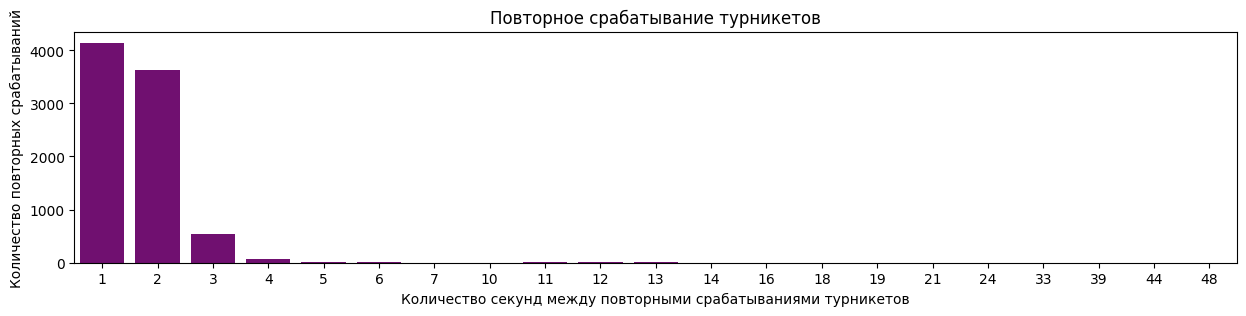

In [39]:
plot_count_sec_btw_repeating_gate_id(df_train)

In [40]:
df_train.query('gate_id == gate_id_lag_1')['gate_id'].value_counts().to_frame().T

gate_id,4,3,5,6,13,10,12,11,9,7,15
count,3268,2070,1883,656,352,324,168,56,34,18,16


In [41]:
for i in range(1, 5):
    print(f'Количество секунд между срабатываниями = {i}:')
    display(df_train.query('gate_id == gate_id_lag_1 and sec_btw_lag_1 == @i')['gate_id'].value_counts().to_frame().T)

Количество секунд между срабатываниями = 1:


gate_id,4,3,5,6,13,12,9
count,1699,927,728,346,257,156,30


Количество секунд между срабатываниями = 2:


gate_id,4,3,5,6,13,12,7
count,1374,961,958,270,63,6,1


Количество секунд между срабатываниями = 3:


gate_id,5,4,3,6,13,7
count,174,166,161,38,5,1


Количество секунд между срабатываниями = 4:


gate_id,4,5,3,7,13
count,24,18,16,2,1


In [42]:
df_train.query('gate_id == gate_id_lag_1')['user_id'].value_counts().to_frame().T

user_id,37,55,6,12,19,15,11,0,33,1,50,39,49,54,32,29,9,3,17,46,14,35,57,24,25,34,26,23,40,56,43,41,22,45,36,2,30,5,21
count,815,687,657,552,515,488,453,353,332,306,295,295,288,273,272,266,252,241,185,168,167,149,143,104,84,80,75,74,72,52,37,31,27,18,16,13,4,4,2


In [43]:
for i in range(1, 5):
    print(f'Количество секунд между срабатываниями = {i}:')
    display(df_train.query('gate_id == gate_id_lag_1 and sec_btw_lag_1 == @i')['user_id'].value_counts().to_frame().T)

Количество секунд между срабатываниями = 1:


user_id,19,6,55,37,15,11,33,12,32,1,49,54,9,29,0,50,17,3,39,57,46,34,25,35,40,24,26,23,41,56,43,45,2,22,14,36,30,21
count,429,340,336,329,253,239,203,195,191,188,168,146,131,109,107,102,98,92,71,66,59,48,37,35,31,29,25,22,15,13,10,6,5,4,4,4,2,1


Количество секунд между срабатываниями = 2:


user_id,55,37,12,15,0,6,11,39,50,29,3,33,54,9,49,1,35,17,46,32,57,19,14,24,26,23,40,25,34,56,43,45,41,22,36,2,5,30,21
count,291,278,264,217,204,178,176,163,160,133,132,123,119,115,110,106,88,83,81,80,69,67,63,47,45,40,35,34,31,28,17,12,12,10,9,7,3,2,1


Количество секунд между срабатываниями = 3:


user_id,14,12,39,0,37,55,50,46,35,24,29,6,3,22,23,25,15,1,43,11,56,49,57,40,54,19,33,36,41,17,9,26,34,32,5
count,75,52,45,37,34,33,28,21,21,20,19,17,16,12,11,10,10,9,9,8,8,7,7,6,5,5,4,3,3,3,2,2,1,1,1


Количество секунд между срабатываниями = 4:


user_id,14,39,12,50,37,35,46,0,6,25,29,23,22,15,41,11,24
count,18,11,7,4,4,3,3,2,1,1,1,1,1,1,1,1,1


Рассмотрим тестовую выборку

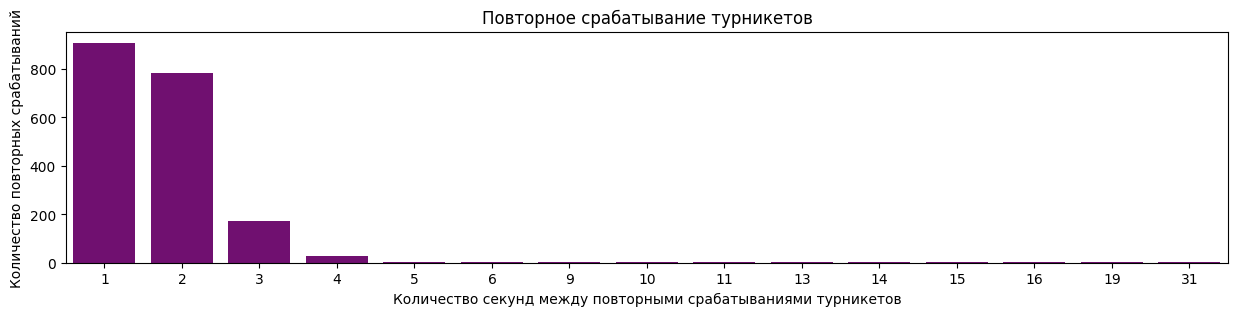

In [44]:
plot_count_sec_btw_repeating_gate_id(df_test)

In [45]:
df_test.query('gate_id == gate_id_lag_1')['gate_id'].value_counts().to_frame().T

gate_id,4,3,5,13,6,12,10,11,15,9,7,8
count,703,437,424,144,134,56,47,8,5,5,4,2


In [46]:
for i in range(1, 5):
    print(f'Количество секунд между срабатываниями = {i}:')
    display(df_test.query('gate_id == gate_id_lag_1 and sec_btw_lag_1 == @i')['gate_id'].value_counts().to_frame().T)

Количество секунд между срабатываниями = 1:


gate_id,4,3,5,13,6,12,9,8
count,328,197,140,119,75,45,4,1


Количество секунд между срабатываниями = 2:


gate_id,4,3,5,6,13,12,7
count,315,198,190,53,17,9,1


Количество секунд между срабатываниями = 3:


gate_id,5,4,3,6,13
count,80,50,33,6,1


Количество секунд между срабатываниями = 4:


gate_id,5,4,3
count,11,9,6


In [47]:
df_test.query('gate_id == gate_id_lag_1')['user_id'].value_counts().to_frame().T

user_id,f1,loss,sigmoid,binary,x,epsilon,collinear,significant,independent,residual,predict,categorical,gini,linear,recall,fit,pvalue,r2,matrix,ols,target,tstat,ridge,distributed,mse,minimization,precision,coefficient,regression,y,lasso,aucroc,blue,logistic
count,230,142,120,109,108,93,85,78,72,68,67,66,63,57,57,52,52,49,46,46,42,41,40,37,30,29,18,16,14,13,13,9,5,2


In [48]:
for i in range(1, 5):
    print(f'Количество секунд между срабатываниями = {i}:')
    display(df_test.query('gate_id == gate_id_lag_1 and sec_btw_lag_1 == @i')['user_id'].value_counts().to_frame().T)

Количество секунд между срабатываниями = 1:


user_id,f1,loss,sigmoid,x,significant,epsilon,pvalue,gini,residual,linear,ols,tstat,binary,fit,r2,matrix,recall,collinear,predict,target,independent,distributed,regression,coefficient,minimization,mse,lasso,ridge,aucroc,categorical,blue,y,precision
count,138,123,67,50,50,49,38,35,34,34,31,29,29,28,25,21,20,20,13,11,10,8,8,7,7,5,5,5,2,2,2,2,1


Количество секунд между срабатываниями = 2:


user_id,f1,binary,sigmoid,epsilon,predict,collinear,x,recall,independent,categorical,residual,significant,gini,target,linear,distributed,ridge,matrix,r2,minimization,mse,fit,loss,pvalue,ols,precision,tstat,coefficient,lasso,regression,y,aucroc,logistic,blue
count,56,53,48,39,39,37,36,36,35,30,29,28,26,24,23,22,21,21,21,20,20,20,18,14,12,11,11,8,7,6,5,4,2,1


Количество секунд между срабатываниями = 3:


user_id,categorical,independent,binary,collinear,predict,x,ridge,distributed,target,y,mse,precision,sigmoid,residual,epsilon,r2,aucroc,matrix,minimization,ols,recall,lasso,gini,fit,f1,blue
count,31,24,18,16,11,9,9,6,6,5,5,4,4,4,3,2,2,2,2,1,1,1,1,1,1,1


Количество секунд между срабатываниями = 4:


user_id,collinear,predict,ridge,categorical,binary,gini,independent,matrix,ols,r2
count,8,4,4,3,2,1,1,1,1,1


Такое поведение некоторых турникетов может быть связано с их неисправностью, либо имеются проблемы с синхронизацией данных, и это приводит к множественным записям в базе данных. Возможно самому человеку приходится прикладывать карту по-нескольку раз.

На основе полученных распределений времени между срабатываниями турникета создадим несколько признаков:

- метка `gate_id`, совпадающего с предыдущим, промежуток между срабатываниями равен 1, 2, 3, 4 секунды и от 5 секунд соответсвенно
- количество повторных срабатываний турникетов для `user_id` в конкретный день, промежуток между срабатываниями 1, 2, 3, 4 секунды и от 5 секунд

<a id='7'></a>
## 5.2 Количество проходов через турникеты в неделю


Рассмотрим тренировочную выборку

In [49]:
week_counts_train = df_train['week_number'].value_counts().sort_index().reset_index()

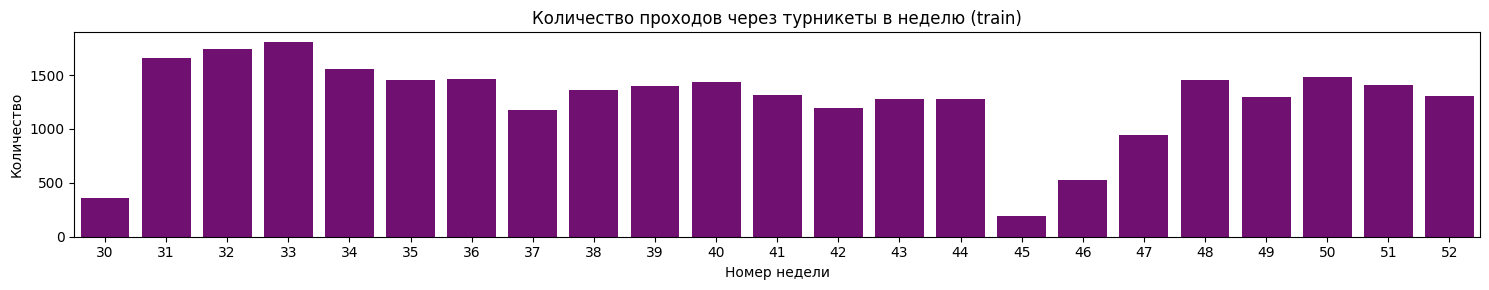

In [50]:
plt.figure(figsize=(15, 3))
sns.barplot(x='week_number', y='count', data=week_counts_train, color='purple')
plt.title('Количество проходов через турникеты в неделю (train)')
plt.xlabel('Номер недели')
plt.ylabel('Количество')
plt.tight_layout()

In [51]:
df_train.loc[df_train['week_number'] == 30, 'date'].nunique()

3

In [52]:
df_train.loc[df_train['week_number'] == 45, 'date'].nunique()

3

Мы видим, что 30 неделя - неполная, как и 45. Поскольку при генерировании признаков мы используем агрегацию по номеру недели, удалим данные за 30 и 45 недели из тренировочной выборки

In [53]:
df_train.shape

(29116, 81)

In [54]:
# df_train = df_train.query('week_number > 30 and week_number != 45').reset_index(drop=True)
# df_train.shape

In [55]:
df_train = df_train.query('week_number > 30').reset_index(drop=True)
df_train.shape

(28752, 81)

In [56]:
df_train['user_id'].nunique()

39

Рассмотрим тестовую выборку

In [57]:
week_counts_test = df_test['week_number'].value_counts().sort_index().reset_index()

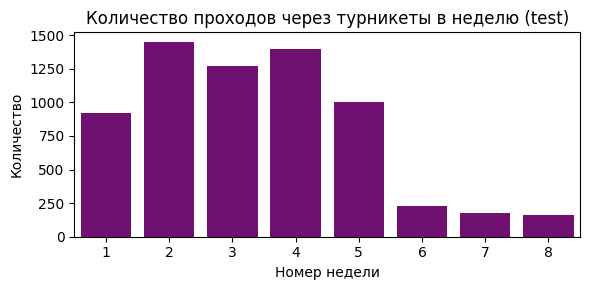

In [58]:
plt.figure(figsize=(6, 3))
sns.barplot(x='week_number', y='count', data=week_counts_test, color='purple')
plt.title('Количество проходов через турникеты в неделю (test)')
plt.xlabel('Номер недели')
plt.ylabel('Количество')
plt.tight_layout()

In [59]:
df_test.loc[df_test['week_number'] == 1, 'date'].nunique()

5

In [60]:
df_test.loc[df_test['week_number'] == 8, 'date'].nunique()

5

Удалим из тестовой выборки данные с 6 по 8 неделю, поскольку в этот период была маленькая активность.

In [61]:
df_test.shape

(6612, 81)

In [62]:
# df_test = df_test.query('week_number < 6').reset_index(drop=True)
# df_test.shape

In [63]:
df_test['user_id'].nunique()

34

In [64]:
df_train = df_train.sort_values('ts').reset_index(drop=True)
df_test = df_test.sort_values('ts').reset_index(drop=True)

# удалим вспомогательные признаков
df_train = df_train.drop(['ts', 'date', 'week_number', 'exit_time', 'temp_sec_btw_lag_1'], axis=1)
df_test = df_test.drop(['ts', 'date', 'week_number', 'exit_time', 'temp_sec_btw_lag_1'], axis=1)

<a id='8'></a>
## 5.3 Phik корреляция признаков с целевым признаком


In [65]:
# %%time
# phik_overview = df_train.phik_matrix()['user_id'].sort_values(ascending=False).to_frame()

In [66]:
# phik_overview.style.background_gradient(cmap='Purples', vmin=0, vmax=1).format('{:.2f}')

<a id='9'></a>
# 6 Построение моделей


<a id='10'></a>
## 6.1 Подготовка данных


In [67]:
y = df_train['user_id']
X = df_train.drop(['user_id'], axis=1)

In [68]:
# выделение обучающей выборки (80 %) и тестовой (20 %)
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE,
                                                    shuffle=True,
                                                    stratify=y
)

In [69]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23001, 75), (5751, 75), (23001,), (5751,))

In [70]:
y_train.nunique(), y_test.nunique()

(39, 39)

In [71]:
X.columns

Index(['gate_id', 'day_of_month', 'hour', 'total_minutes', 'total_seconds',
       'day_of_week', 'is_weekend', 'time_of_day', 'is_month_start',
       'is_month_end', 'pass_cnt_per_day', 'daily_gate_pass_count',
       'probability_gate_id', 'cnt_users_per_day', 'cnt_users_per_week',
       'daily_attendance_index', 'cnt_days_per_week', 'nunique_gate_per_day',
       'nunique_gate_per_week', 'nunique_gate_per_day_of_week',
       'avg_pass_count_per_day_of_week', 'avg_gate_pass_count_per_day_of_week',
       'entry_time', 'working_time_per_day', 'entrance_gate_id',
       'exit_gate_id', 'working_time_per_week', 'daily_workload_index',
       'avg_working_time_per_day_of_week', 'avg_entry_time_per_day_of_week',
       'gate_id_lag_1', 'gate_id_1', 'sec_btw_lag_1', 'sec_btw_1',
       'gate_id_lag_2', 'gate_id_2', 'sec_btw_lag_2', 'sec_btw_2',
       'gate_id_lag_3', 'gate_id_3', 'sec_btw_lag_3', 'sec_btw_3',
       'gate_id_lag_4', 'gate_id_4', 'sec_btw_lag_4', 'sec_btw_4',
       'ga

In [72]:
categorical_features = [
    'gate_id', 
    'day_of_month', 
    'hour',
    'day_of_week', 
    'is_weekend', 
    'time_of_day', 
    'is_month_start',
    'is_month_end', 
    'entrance_gate_id',
    'exit_gate_id', 
    'gate_id_lag_1', 
    'gate_id_1', 
    'gate_id_lag_2', 
    'gate_id_2', 
    'gate_id_lag_3', 
    'gate_id_3', 
    'gate_id_lag_4', 
    'gate_id_4', 
    'gate_id_lag_5', 
    'gate_id_5', 
    'repeat_gate_1s', 
    'repeat_gate_2s', 
    'repeat_gate_3s', 
    'repeat_gate_4s',
    'repeat_gate_ge_5s', 
    'route', 
    'most_frequent_gate_per_day', 
    'most_frequent_gate_per_week',
    'most_frequent_route_per_day', 
    'most_frequent_route_per_week',
    'most_frequent_entrance_gate_per_week',
    'most_frequent_exit_gate_per_week',
    'most_frequent_gate_per_day_of_week',
    'most_frequent_route_per_day_of_week'
]

<a id='11'></a>
## 6.2 Подбор гиперпараметров


Будем работать с `CatBoostClassifier`.

Оптимизация гиперпараметров проводилась с помощью фреймворка `Optuna`.

В качестве валидационной метрики, используемой для обнаружения переобучения и ранней остановки, выступала F1-мера с параметром `average='macro'`. В таком случае вычисляется F1-мера для каждого класса отдельно, затем полученные значения усредняются.

Использовали `StratifiedKFold` валидацию.

In [73]:
def fit_catboost(trial, train, val, cat_features):
    X_train, y_train = train
    X_val, y_val = val
    # параметры для перебора
    param = {
        'n_estimators' : 2000, # можно не перебирать, есть Early-Stopping
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3.0, 60.0),        
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 'None']),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'border_count': trial.suggest_int('border_count', 32, 128)
    }

    clf = CatBoostClassifier(
        **param,
        loss_function='MultiClassOneVsAll',
        eval_metric='TotalF1:average=Weighted',
        random_seed=RANDOM_STATE,
        cat_features=cat_features,
        thread_count=-1,
        task_type='GPU',
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        verbose=100,
        plot=False,
        early_stopping_rounds=100,
    )

    y_pred = clf.predict(X_val)
    return clf, y_pred

In [74]:
def objective(trial, X, y, cat_features, return_models=False):
    n_splits = 3
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    scores, models = [], []
    
    for train_idx, valid_idx in skf.split(X, y):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # подаем trials для перебора
        model, y_pred = fit_catboost(trial, train_data, valid_data, cat_features) # определили выше
        scores.append(f1_score(valid_data[1], y_pred, average='weighted'))
        models.append(model)
         

    result = np.mean(scores)
    
    if return_models:
        return result, models
    else:
        return result

In [75]:
%%time

study = optuna.create_study(direction='maximize')
study.optimize(
                lambda trial: objective(trial, X, y, categorical_features),
                n_trials=3,
                show_progress_bar=True,
)

[I 2024-08-19 20:18:41,802] A new study created in memory with name: no-name-99f8a0ee-ca5d-4970-abb4-8d1c15bb5c8e


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.8053846	test: 0.8060750	best: 0.8060750 (0)	total: 200ms	remaining: 6m 39s
100:	learn: 0.9355263	test: 0.9368122	best: 0.9370731 (97)	total: 17.1s	remaining: 5m 22s
200:	learn: 0.9527308	test: 0.9541444	best: 0.9544482 (184)	total: 34.9s	remaining: 5m 12s
300:	learn: 0.9732408	test: 0.9742854	best: 0.9743183 (289)	total: 53.4s	remaining: 5m 1s
400:	learn: 0.9819210	test: 0.9822062	best: 0.9822062 (384)	total: 1m 13s	remaining: 4m 52s
500:	learn: 0.9871960	test: 0.9859930	best: 0.9859930 (496)	total: 1m 32s	remaining: 4m 37s
600:	learn: 0.9889796	test: 0.9875875	best: 0.9875875 (597)	total: 1m 52s	remaining: 4m 21s
700:	learn: 0.9909430	test: 0.9891476	best: 0.9891737 (695)	total: 2m 11s	remaining: 4m 3s
800:	learn: 0.9917560	test: 0.9902208	best: 0.9902208 (783)	total: 2m 31s	remaining: 3m 46s
900:	learn: 0.9926803	test: 0.9907695	best: 0.9910608 (864)	total: 3m 5s	remaining: 3m 46s
bestTest = 0.9910608024
bestIteration = 864
Shrink model to first 865 iterations.
0:	learn: 

In [76]:
print(f'Best trial: score {study.best_trial.value}, params {study.best_trial.params}')

Best trial: score 0.9944359116662423, params {'learning_rate': 0.01814583323064944, 'l2_leaf_reg': 51.00632052416254, 'auto_class_weights': 'None', 'max_depth': 10, 'border_count': 112}


In [77]:
%%time

# обучение итоговых моделей на подобранных гиперпараметрах
valid_scores, models_all_features = objective(
    optuna.trial.FixedTrial(study.best_params),
    X, 
    y, 
    categorical_features,
    return_models=True,
)

0:	learn: 0.8053846	test: 0.8060750	best: 0.8060750 (0)	total: 373ms	remaining: 12m 25s
100:	learn: 0.9355263	test: 0.9368122	best: 0.9370731 (97)	total: 38s	remaining: 11m 54s
200:	learn: 0.9527308	test: 0.9541444	best: 0.9544482 (184)	total: 1m 16s	remaining: 11m 23s
300:	learn: 0.9732408	test: 0.9742854	best: 0.9743183 (289)	total: 1m 55s	remaining: 10m 51s
400:	learn: 0.9819210	test: 0.9822062	best: 0.9822062 (384)	total: 2m 36s	remaining: 10m 22s
500:	learn: 0.9871960	test: 0.9859930	best: 0.9859930 (496)	total: 3m 16s	remaining: 9m 46s
600:	learn: 0.9889796	test: 0.9875875	best: 0.9875875 (597)	total: 3m 55s	remaining: 9m 8s
700:	learn: 0.9909430	test: 0.9891476	best: 0.9891737 (695)	total: 4m 35s	remaining: 8m 30s
800:	learn: 0.9917560	test: 0.9902208	best: 0.9902208 (783)	total: 5m 15s	remaining: 7m 51s
900:	learn: 0.9926803	test: 0.9907695	best: 0.9910608 (864)	total: 5m 54s	remaining: 7m 12s
bestTest = 0.9910608024
bestIteration = 864
Shrink model to first 865 iterations.
0:	

In [78]:

# среднее значение f1_score на кросс-валидации
print(valid_scores)
# количество деревьев
for m in models_all_features:
    print(m.tree_count_)


0.9944359116662423
865
1362
924


Подобранные гиперпараметры использовались в дальнейшем при отборе признаков.

<a id='12'></a>
## 6.3 Отбор признаков


Отбор признаков проводился с помощью метода у CatBoost - `.select_features()`. Это метод-обертка, который рекурсивно удаляет признаки на основе оценки важности для каждого признака. Использовали самый точный алгоритм рекурсивного удаления признаков - `RecursiveByShapValues`.

В качестве гиперпараметров `CatBoostClassifier` использовали найденные на предыдущем этапе.

В результате отобрали 18 признаков:

    'most_frequent_route_per_week',
    'working_time_per_week',
    'entry_time',
    'cnt_users_per_day',
    'cnt_repeat_gate_3s',
    'most_frequent_route_per_day',
    'route_avg_time',
    'daily_attendance_index',
    'cnt_repeat_gate_2s',
    'exit_gate_id',
    'daily_workload_index',
    'cnt_repeat_gate_1s',
    'entrance_gate_id',
    'working_time_per_day',
    'pass_cnt_per_day',
    'cnt_users_per_week',
    'cnt_days_per_week',
    'most_frequent_gate_per_week'

Ниже представлен код, с помощью которого происходил отбор признаков.


In [79]:

# создаем список имен признаков
feature_names = list(X_train.columns)

# создаем обучающий и проверочный пулы
train_pool = Pool(X_train, 
                  y_train,
                  feature_names=feature_names, 
                  cat_features=categorical_features)

test_pool = Pool(X_test, 
                 y_test, 
                 feature_names=feature_names, 
                 cat_features=categorical_features)


In [80]:
# пишем функцию отбора признаков на основе рекурсивного удаления признаков
def catboost_select_features(algorithm, steps=1):
    print('Algorithm:', algorithm)
    model = CatBoostClassifier(
                    **study.best_params,
                    n_estimators=1100,
                    random_seed=RANDOM_STATE,
                    loss_function='MultiClassOneVsAll',
                    eval_metric='TotalF1:average=Weighted',
                    thread_count=-1,
                    task_type='GPU'
    )
    summary = model.select_features(
        # обучающий пул
        train_pool,
        # проверочный пул
        eval_set=test_pool,
        # список признаков, участвующих в отборе
        features_for_select=list(range(train_pool.num_col())),
        # количество отбираемых признаков
        num_features_to_select=3,
        # количество итераций обучения модели, вычисляющей оценки важностей (чем больше, тем лучше качество)
        steps=steps,
        # алгоритм отбора
        algorithm=algorithm,
        # метод вычисления значений SHAP
        shap_calc_type=EShapCalcType.Regular,
        # обучаем модель с отобранными признаками
        train_final_model=True,
        # уровень детализации вывода
        logging_level='Silent',
        # отрисовка кривых обучения и валидации
        plot=True
    )
    print('Selected features:', summary['selected_features_names'])
    return summary


In [81]:

%%time

# выполняем отбор признаков
shap_summary = catboost_select_features(
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, 
    steps=5
)


Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['nunique_gate_per_day_of_week', 'avg_gate_pass_count_per_day_of_week', 'avg_entry_time_per_day_of_week']
CPU times: total: 3h 52min 51s
Wall time: 29min 57s


In [82]:
print(shap_summary['loss_graph'])

{'main_indices': [0, 36, 54, 64, 69, 72], 'removed_features_count': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72], 'loss_values': [0.00998590996754251, 0.009599834671060277, 0.009584757383342107, 0.009584733099459026, 0.009584733099459028, 0.009584733099459028, 0.009584733099459028, 0.009584733099459028, 0.009584733099459028, 0.009584733099459028, 0.009584733099459028, 0.009584733099459028, 0.00958473309945903, 0.00958473309945903, 0.00958473309945903, 0.00958473309945903, 0.00958473309945903, 0.00958473309945903, 0.00958473309945903, 0.00958473309945903, 0.00958473309945903, 0.00958473309945903, 0.00958473309945903, 0.00958473309945903, 0.00958473309945903, 0.00958473309945903, 0.00958473309945903, 0.00958473309945903, 0.00958473309945903, 0.0095847330

In [83]:
loss_values = shap_summary['loss_graph']['loss_values']
loss_values.index(min(loss_values))

69

На основе графика `Loss by eliminated features`, отберем из списка `eliminated_feat` фичи, начиная с 44-го индекса.

In [84]:
# отобранные признаки
selected_feat = shap_summary['selected_features_names']
selected_feat

['nunique_gate_per_day_of_week',
 'avg_gate_pass_count_per_day_of_week',
 'avg_entry_time_per_day_of_week']

In [85]:
# исключенные признаки
eliminated_feat = shap_summary['eliminated_features_names']
print(eliminated_feat)

['is_weekend', 'working_time_per_week', 'nunique_gate_per_day', 'gate_id', 'day_of_month', 'hour', 'total_minutes', 'total_seconds', 'day_of_week', 'time_of_day', 'is_month_start', 'is_month_end', 'pass_cnt_per_day', 'daily_gate_pass_count', 'probability_gate_id', 'cnt_users_per_day', 'nunique_gate_per_week', 'entry_time', 'working_time_per_day', 'entrance_gate_id', 'exit_gate_id', 'gate_id_lag_1', 'repeat_gate_4s', 'repeat_gate_ge_5s', 'cnt_repeat_gate_2s', 'cnt_repeat_gate_4s', 'cnt_repeat_gate_ge_5s', 'route', 'cumtime_per_day', 'cumtime_at_route_per_day', 'most_frequent_gate_per_day', 'most_frequent_gate_per_week', 'most_frequent_route_per_day', 'most_frequent_route_per_week', 'most_frequent_entrance_gate_per_week', 'most_frequent_exit_gate_per_week', 'daily_attendance_index', 'nunique_route_per_week', 'cnt_repeat_gate_3s', 'most_frequent_gate_per_day_of_week', 'most_frequent_route_per_day_of_week', 'weekly_route_avg_time', 'route_avg_time', 'gate_id_1', 'sec_btw_lag_1', 'sec_btw_1

In [86]:
# selected_features = selected_feat + eliminated_feat[loss_values.index(min(loss_values)) - 1:]
selected_features = selected_feat + eliminated_feat[33:]
selected_features

['nunique_gate_per_day_of_week',
 'avg_gate_pass_count_per_day_of_week',
 'avg_entry_time_per_day_of_week',
 'most_frequent_route_per_week',
 'most_frequent_entrance_gate_per_week',
 'most_frequent_exit_gate_per_week',
 'daily_attendance_index',
 'nunique_route_per_week',
 'cnt_repeat_gate_3s',
 'most_frequent_gate_per_day_of_week',
 'most_frequent_route_per_day_of_week',
 'weekly_route_avg_time',
 'route_avg_time',
 'gate_id_1',
 'sec_btw_lag_1',
 'sec_btw_1',
 'gate_id_lag_2',
 'gate_id_2',
 'sec_btw_lag_2',
 'sec_btw_2',
 'gate_id_lag_3',
 'gate_id_3',
 'sec_btw_lag_3',
 'sec_btw_3',
 'daily_workload_index',
 'gate_id_lag_4',
 'cnt_users_per_week',
 'gate_id_4',
 'repeat_gate_2s',
 'repeat_gate_3s',
 'cnt_repeat_gate_1s',
 'sec_btw_lag_4',
 'sec_btw_4',
 'gate_id_lag_5',
 'gate_id_5',
 'sec_btw_lag_5',
 'sec_btw_5',
 'repeat_gate_1s',
 'cnt_days_per_week',
 'avg_pass_count_per_day_of_week',
 'nunique_route_per_day_of_week',
 'avg_working_time_per_day_of_week']

In [87]:
len(selected_features)

42

In [88]:
cat_features = [
    'most_frequent_route_per_week',
    'most_frequent_entrance_gate_per_week',
    'most_frequent_exit_gate_per_week',
    'most_frequent_gate_per_day_of_week',
    'most_frequent_route_per_day_of_week',
    'gate_id_1',
    'gate_id_lag_2',
    'gate_id_2',
    'gate_id_lag_3',
    'gate_id_3',
    'gate_id_lag_4',
    'gate_id_4',
    'repeat_gate_2s',
    'repeat_gate_3s',
    'gate_id_lag_5',
    'gate_id_5',
    'repeat_gate_1s',
]

<a id='13'></a>
## 6.4 Подбор гиперпараметров после отбора признаков


In [89]:
%%time

study = optuna.create_study(direction='maximize')
study.optimize(
                lambda trial: objective(trial, X[selected_features], y, cat_features),
                n_trials=3,
                show_progress_bar=True,
)

[I 2024-08-19 21:52:32,258] A new study created in memory with name: no-name-be494783-e961-4663-9fff-959af7b39c51


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.8124647	test: 0.8132890	best: 0.8132890 (0)	total: 146ms	remaining: 4m 51s
100:	learn: 0.9634444	test: 0.9653469	best: 0.9653469 (99)	total: 11.1s	remaining: 3m 28s
200:	learn: 0.9866787	test: 0.9852887	best: 0.9853247 (198)	total: 22.3s	remaining: 3m 19s
300:	learn: 0.9906942	test: 0.9887193	best: 0.9887193 (288)	total: 34.1s	remaining: 3m 12s
400:	learn: 0.9933884	test: 0.9908342	best: 0.9908342 (383)	total: 46s	remaining: 3m 3s
500:	learn: 0.9950499	test: 0.9926311	best: 0.9926311 (496)	total: 58.2s	remaining: 2m 54s
600:	learn: 0.9956608	test: 0.9937199	best: 0.9937199 (584)	total: 1m 10s	remaining: 2m 44s
700:	learn: 0.9958646	test: 0.9942207	best: 0.9945251 (684)	total: 1m 23s	remaining: 2m 34s
800:	learn: 0.9972886	test: 0.9964449	best: 0.9964449 (756)	total: 1m 36s	remaining: 2m 23s
900:	learn: 0.9983833	test: 0.9971689	best: 0.9971689 (875)	total: 1m 48s	remaining: 2m 12s
1000:	learn: 0.9988370	test: 0.9977932	best: 0.9977932 (995)	total: 1m 59s	remaining: 1m 59s
1

In [90]:
print(f'Best trial: score {study.best_trial.value}, params {study.best_trial.params}')

Best trial: score 0.9994071292331773, params {'learning_rate': 0.05906259751031983, 'l2_leaf_reg': 33.14796782529599, 'auto_class_weights': 'None', 'max_depth': 10, 'border_count': 72}


In [91]:
%%time

valid_scores, models = objective(
    optuna.trial.FixedTrial(study.best_params),
    X[selected_features], 
    y, 
    cat_features,
    return_models=True,
)

0:	learn: 0.7869961	test: 0.7881646	best: 0.7881646 (0)	total: 259ms	remaining: 8m 37s
100:	learn: 0.9794645	test: 0.9799692	best: 0.9799692 (96)	total: 26.6s	remaining: 8m 19s
200:	learn: 0.9933561	test: 0.9919649	best: 0.9922465 (195)	total: 53.3s	remaining: 7m 57s
300:	learn: 0.9963051	test: 0.9953317	best: 0.9953403 (282)	total: 1m 20s	remaining: 7m 32s
400:	learn: 0.9980484	test: 0.9978365	best: 0.9978365 (361)	total: 1m 46s	remaining: 7m 5s
500:	learn: 0.9992461	test: 0.9987666	best: 0.9987666 (478)	total: 2m 13s	remaining: 6m 39s
600:	learn: 0.9995583	test: 0.9993893	best: 0.9993893 (572)	total: 2m 40s	remaining: 6m 13s
bestTest = 0.9993892973
bestIteration = 572
Shrink model to first 573 iterations.
0:	learn: 0.8175071	test: 0.8157545	best: 0.8157545 (0)	total: 258ms	remaining: 8m 36s
100:	learn: 0.9773575	test: 0.9736229	best: 0.9736229 (100)	total: 26.5s	remaining: 8m 18s
200:	learn: 0.9925802	test: 0.9918995	best: 0.9918995 (190)	total: 53.2s	remaining: 7m 55s
300:	learn: 0.

In [92]:
print(f'Среднее значение F1-меры на кросс-валидации: {valid_scores:.3f}')

Среднее значение F1-меры на кросс-валидации: 0.999


In [93]:
# количество деревьев
for m in models:
    print(m.tree_count_)

573
559
682


<a id='14'></a>
## 6.5 Итоговое предсказание лучшей модели


In [94]:
def make_prediction_dict(df_test, name_columns, models):
    # из тестового набора выделяем фичи, на которых обучались
    X = df_test.loc[:, name_columns]
    # датафрейм с закодированными user_id из тестовой выборки
    result = df_test.loc[:, ['user_word']]
    # делаем предсказания user_id
    predictions = np.array([model.predict(X) for model in models])
    result['pred_user_id'] = mode(predictions, axis=0)[0].flatten()
    result = result.groupby('user_word')['pred_user_id'].agg(lambda group: dict(group.value_counts())).to_dict()
    return result

In [95]:
def make_prediction(df_test, name_columns, models):
    # из тестового набора выделяем фичи, на которых обучались
    X = df_test.loc[:, name_columns]
    # датафрейм с закодированными user_id из тестовой выборки
    result = df_test.loc[:, ['user_word']]
    # делаем предсказания user_id
    predictions = np.array([model.predict(X) for model in models])
    result['pred_user_id'] = mode(predictions, axis=0)[0].flatten()
    # датафрейм: user_word; предсказанный user_id; количество предсказанных конкретных user_id 
    # для конкретной категории user_word
    temp_1 = result.groupby(['user_word', 'pred_user_id']).size().reset_index(name='count_pred_user_id_in_user_word')
    # датафрейм: user_word; количество user_word
    temp_2 = result['user_word'].value_counts().reset_index(name='count_user_word')
    # датафрейм: pred_user_id; количество pred_user_id
    temp_3 = result['pred_user_id'].value_counts().reset_index(name='count_pred_user_id')
    # датафрейм: user_word; pred_user_id; count_pred_user_id_in_user_word; count_user_word; count_pred_user_id
    result = temp_1.merge(temp_2, on='user_word', how='left').merge(temp_3, on='pred_user_id', how='left')
    # добавляем уверенность модели в том, что предсказанный user_id, соответсвует user_word, 
    # в знаменателе - кол-во user_word
    result['confidence_per_user_word'] = result['count_pred_user_id_in_user_word'] / result['count_user_word']
    # добавляем уверенность модели в том, что предсказанный user_id, соответсвует user_word, 
    # в знаменателе - кол-во pred_user_id
    result['confidence_per_pred_user_id'] = result['count_pred_user_id_in_user_word'] / result['count_pred_user_id']
    # итоговая уверенность
    result['confidence'] = result['confidence_per_user_word'] + result['confidence_per_pred_user_id']
    # сортируем данные по убыванию уверенности
    result = result.sort_values(by='confidence', ascending=False)

    # формируем итоговый датафрейм
    final = pd.DataFrame(columns=['user_word', 'preds'])
    # user_word, которые уже добавлены в final
    words = set()
    # user_id, которые уже добавлены в final
    ids = set()
    # добавляем в final предсказания по приоритету уверенности (result уже отсортирован)
    for _, row in result.iterrows():
        word, user_id = row['user_word'], row['pred_user_id']
        if word not in words and user_id not in ids and row['confidence'] > 0.1:
            final.loc[len(final)] = [word, user_id]
            words.add(word)
            ids.add(user_id)

    # категориям, насчет которых модель не уверена, проставляется -999
    for word in (set(result['user_word'].unique()) - set(final['user_word'])):
        final.loc[len(final)] = [word, -999]
    
    return final.sort_values(by='user_word')

In [96]:
df_test = df_test.rename(columns={'user_id': 'user_word'})

Сделаем предсказание

После удаления фичей, уменьшающих скор, и повторного подбора гиперпараметров

In [97]:
make_prediction_dict(df_test, selected_features, models)

{'aucroc': {23: 18, 43: 17, 36: 2},
 'binary': {9: 149, 12: 120, 15: 70, 40: 23},
 'blue': {25: 7, 36: 5},
 'categorical': {14: 160, 40: 73, 45: 7, 3: 1},
 'coefficient': {3: 34, 46: 19, 5: 3},
 'collinear': {40: 56,
  49: 48,
  14: 46,
  0: 43,
  29: 27,
  12: 26,
  9: 25,
  46: 18,
  3: 5,
  17: 4},
 'distributed': {57: 38, 17: 26, 36: 14, 35: 14, 32: 13, 46: 12},
 'epsilon': {17: 111, 55: 98, 35: 73, 32: 39, 41: 15},
 'f1': {37: 360, 19: 157, 6: 54, 55: 51, 9: 28, 12: 23, 49: 20},
 'fit': {57: 58, 3: 36, 17: 34, 1: 27, 32: 21, 35: 7},
 'gini': {57: 91, 3: 62, 17: 54, 1: 17, 32: 12, 24: 8, 5: 8},
 'independent': {35: 88,
  14: 56,
  9: 48,
  23: 31,
  25: 16,
  17: 15,
  22: 14,
  34: 10},
 'lasso': {40: 18, 17: 10, 36: 5},
 'linear': {17: 160, 3: 39},
 'logistic': {36: 5},
 'loss': {19: 237, 35: 79, 9: 71, 25: 40, 6: 31},
 'matrix': {23: 85, 9: 32, 3: 16, 24: 9, 34: 8, 32: 7},
 'minimization': {32: 77, 24: 8, 14: 6, 40: 4},
 'mse': {43: 63, 14: 40},
 'ols': {3: 58, 9: 40, 35: 33, 34

In [98]:
result_cb = make_prediction(df_test, selected_features, models)
result_cb

,user_word,preds
29,aucroc,-999
11,binary,12
20,blue,25
4,categorical,14
30,coefficient,-999
5,collinear,29
28,distributed,-999
9,epsilon,41
1,f1,37
23,fit,57


In [99]:
len(result_cb)

34

Сохраним результаты

In [ ]:
# csv_buffer = io.StringIO()

# result_cb.to_csv(csv_buffer, index=False)

# with zipfile.ZipFile('../data/answer.zip', mode='w', compression=zipfile.ZIP_DEFLATED) as zf:
#     zf.writestr('answer.csv', csv_buffer.getvalue())

In [100]:
result_cb.to_csv('../data/cb_ova_v_02.csv', index=False)

In [101]:
right_answers = pd.read_csv(r'E:\projects\SHIFT\предыдущие_наработки\right_answers.csv')
res_ivan = pd.read_csv(r'E:\projects\SHIFT\От_Ивана\ШИФТ тест\Решения\1) 04_02_2024\answer_ivan.csv')
res_vera = pd.read_csv(r'E:\projects\SHIFT\От_Ивана\ШИФТ тест\Решения\4) Ivanova_Vera_SaintPetersburg 358\shift_ml-main\answer_vera.csv')
res_cb_best = pd.read_csv('../data/submit_cb_v_05_sf_new_fit_374.csv')

res_cb_ova_00 = pd.read_csv('../data/cb_ova_v_00.csv')

res_cb_ova_01 = pd.read_csv('../data/cb_ova_v_01.csv')

res_cb_ova_02 = pd.read_csv('../data/cb_ova_v_02.csv')

In [102]:
res = right_answers.loc[:].rename(columns={'preds': 'right_answers'})
res['right_answers'] = res['right_answers'].apply(lambda x: f'{x:.0f}')
res['ivan'] = res_ivan['preds']
res['vera'] = res_vera['preds']
res['cb_best_374'] = res_cb_best['preds']
res['cb_ova_v_00'] = res_cb_ova_00['preds']
res['cb_ova_v_01'] = res_cb_ova_01['preds']

res['cb_ova_v_02'] = res_cb_ova_02['preds']

In [103]:
# Функция для условного форматирования
def highlight_matching_cells(x):
    ref_col = x['vera']
    df_styled = pd.DataFrame('', index=x.index, columns=x.columns)
    for col in x.columns:
        if col == 'right_answers':
            df_styled[col] = ['background-color: red' if x[col].iloc[i] != 'nan' else '' for i in range(len(x))]
        elif col != 'vera':
            df_styled[col] = ['background-color: green' if x[col].iloc[i] == ref_col.iloc[i] else '' for i in range(len(x))]
    return df_styled

# Применение стиля
res.style.apply(highlight_matching_cells, axis=None)

,user_word,right_answers,ivan,vera,cb_best_374,cb_ova_v_00,cb_ova_v_01,cb_ova_v_02
0,aucroc,24,24,24,24,24,41,-999
1,binary,12,12,12,12,12,9,12
2,blue,56,-999,56,56,36,36,25
3,categorical,14,14,14,14,14,14,14
4,coefficient,nan,-999,27,-999,7,2,-999
5,collinear,nan,-999,23,22,31,25,29
6,distributed,0,0,0,0,0,57,-999
7,epsilon,1,1,1,1,18,15,41
8,f1,6,6,18,6,37,37,37
9,fit,2,23,6,2,20,-999,57
